In [1]:
using Revise

In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1423


In [3]:
using PotentialFlow

In [4]:
using Plots
pyplot()

┌ Warning: Replacing module `PlotUtils`
└ @ Base loading.jl:1036


Plots.PyPlotBackend()

In [5]:
using Distributions
using Random
using LinearAlgebra

In [6]:
Random.seed!(1234)

TaskLocalRNG()

### Evaluation grids and sensors

In [7]:
# grid for full field evaluation
xmin, xmax = -2.5, 2.5
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)
zg = xg .+ im*yg';

# sensors on a grid
#=
xmin, xmax = -2.5, 2.5
xsens = range(xmin,xmax,length=81)
ysens = range(xmin,xmax,length=81)
zsens = xsens .+ im*ysens';
sens = vec(zsens);
=#

# sensors in a circle
rsens = 1.5
Nsens = 11
θsens = range(0,2π,length=Nsens+1)
#sens = rsens*exp.(im*θsens[1:end-1]);

# sensors in lines
lowerrow = range(-2.0,2.0,length=11) .- 0.0*im
upperrow = range(-2.0,2.0,length=11) .+ 1.0*im
#leftside = im*range(-1.0,3.0,length=41) .- 1.0
#rightside = im*range(-1.0,3.0,length=41) .+ 1.0
sens = vcat(lowerrow,);  #upperrow);

### Truth

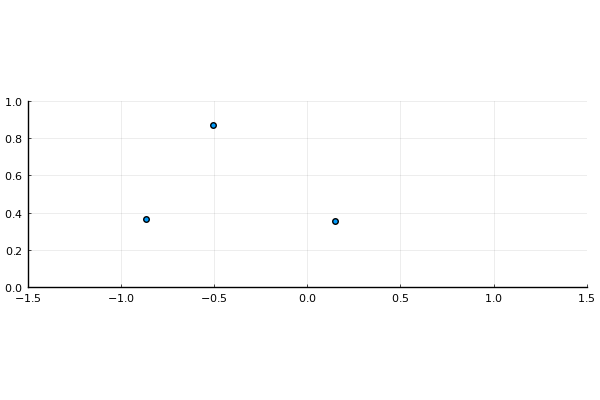

In [8]:
Nv_cluster = 3
Nv_per_cluster = 1 #5
z0 = 0.75im #complex(0.0)
Γ0 = 1.0
δ_true = 0.01
xr = (-1.5,1.5)
yr = (0.0,1.0)
Γr = (0.0,2.0)
σx = 0.03
σΓ = 0.03
Nv_true = Nv_cluster*Nv_per_cluster 

zv, Γv = createclusters(Nv_cluster,Nv_per_cluster,xr,yr,Γr,σx,σΓ,each_cluster_radius=1.5*σx)

config_data_true = VortexConfig(Nv_true, δ_true,body=LowRankVortex.NoWall)


vort = Vortex.Blob.(zv,Γv,δ_true)
x_true = lagrange_to_state_reordered(vort,config_data_true);

scatter(real.(zv),imag.(zv),ratio=1,xlim=xr,ylim=yr,legend=false)

In [9]:
ptrue_field = analytical_pressure(zg,vort,config_data_true);

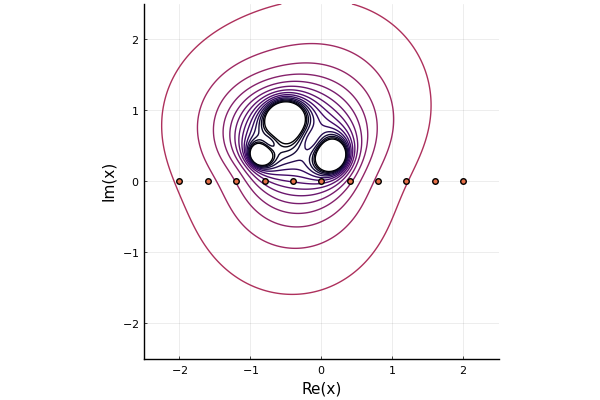

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [10]:
l = range(-1,1,length=31)
cl = (-1,1)
contour(xg,yg,ptrue_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(-2.5,2.5),ylim=(-2.5,2.5))
scatter!(sens)

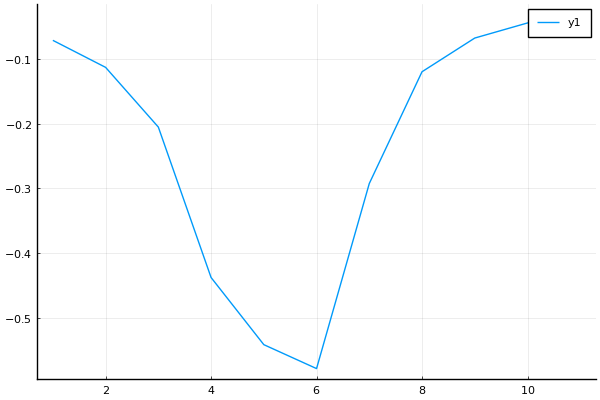

In [11]:
ystar = analytical_pressure(sens,vort,config_data_true);
plot(ystar)

## Single vortex estimation

In [12]:
Nv_one = 1
δ = 0.01

config_1vortex_data = VortexConfig(Nv_one, δ, body=LowRankVortex.NoWall)

# prior
ϵmeas = 5e-4 #1e-3
ϵX = 5e-3 #0.05
ϵΓ = 5e-3 #0.05

# ranges to confine the prior mean to
xr = (-1.5,1.5)
yr = (0.0,1.0)
Γr = (0.0,2.0)

(0.0, 2.0)

In [17]:
sol_collection = vortexinference(1,sens,ystar,xr,yr,Γr,ϵmeas,ϵX,ϵX,ϵΓ,config_1vortex_data,linear_flag=false,numsample=5,inflate=true);

In [18]:
collection_err = map(x -> x[end].yerr,sol_collection)

5-element Vector{Float64}:
 233.69106619223106
 233.73141694924036
 233.67728088513252
 233.79421790345333
 233.71060308438058

In [19]:
minerr, sampnum = findmin(collection_err)
solhist = sol_collection[sampnum];

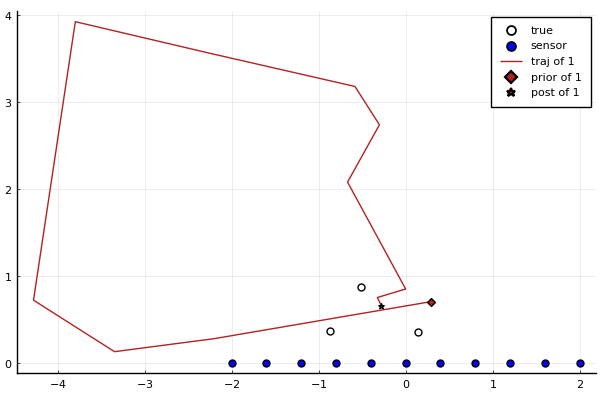

In [20]:
pl = filtertrajectory(solhist,sens,vort,config_1vortex_data)
#savefig("3cluster-traj-1vortex-wall-11linesensors.pdf")
#display(pl)

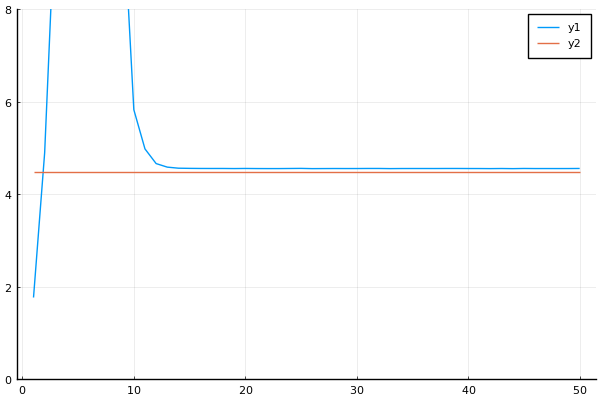

In [21]:
plot(map(x -> mean(x.Xf)[3],solhist),ylim=(0,8))
plot!(sum(x_true[2Nv_true+1:3Nv_true])*ones(length(solhist)))

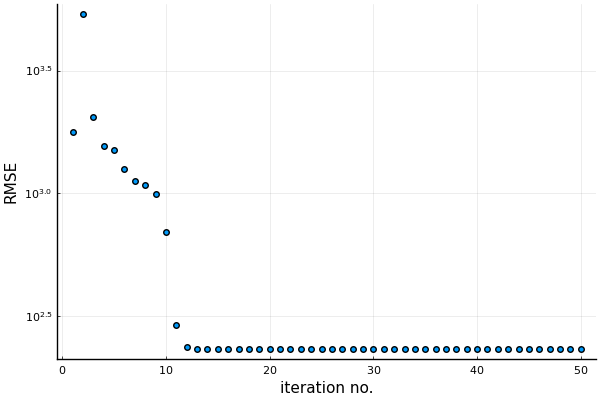

In [22]:
yerrhist = map(x -> x.yerr,solhist)
pl = scatter(yerrhist,yscale=:log10,xlabel="iteration no.",ylabel="RMSE",legend=false)
#savefig("3cluster-error-1vortex-wall-11linesensors.pdf")
#display(pl)

In [23]:
zmean_1vortex, Γmean_1vortex = state_to_positions_and_strengths(mean(solhist[end].X),config_1vortex_data)
transpose([vortexmoment(0,zv,Γv) vortexmoment(0,zmean_1vortex,Γmean_1vortex) vortexmoment(1,zv,Γv)/vortexmoment(0,zv,Γv) vortexmoment(1,zmean_1vortex,Γmean_1vortex)/vortexmoment(0,zmean_1vortex,Γmean_1vortex)])

4×1 transpose(::Matrix{ComplexF64}) with eltype ComplexF64:
   4.477676041863966 + 0.0im
   4.552288791255664 + 0.0im
 -0.3548477675248167 + 0.5796993474704174im
  -0.277789067339513 + 0.650708753312372im

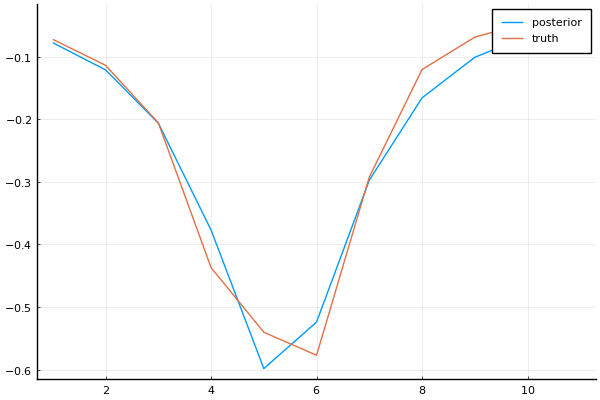

In [24]:
vort_post = state_to_lagrange_reordered(mean(solhist[end].X),config_1vortex_data;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = analytical_pressure(sens,vort_post,config_1vortex_data)
p_post_field = analytical_pressure(zg,vort_post,config_1vortex_data)
vort_post
plot(y_post,label="posterior")
plot!(ystar,label="truth")

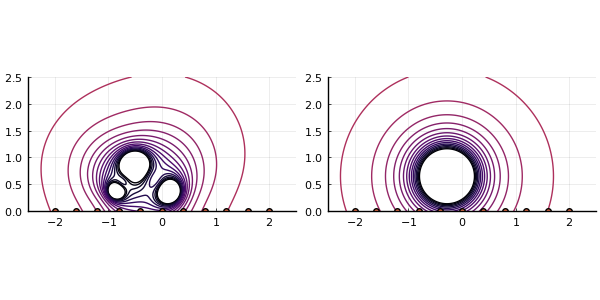

In [25]:
l = range(-1,1,length=31)
cl = (-1,1)
pl1 = plot(xg,yg,ptrue_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(0.0,xmax))
scatter!(pl1,real.(sens),imag.(sens))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = plot(xg,yg,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(0.0,xmax))
scatter!(pl2,real.(sens),imag.(sens))
p1 = plot(pl1,pl2,size=(600,300))
#savefig("3cluster-pfield-1vortex-wall-11linesensors.pdf")
#display(p1)

In [26]:
solhist[end].V

3×3 Matrix{Float64}:
 -0.00755809   0.999962    -0.00429278
 -0.985451    -0.00671935   0.169826
  0.169791     0.00551389   0.985465

In [27]:
solhist[end].Λx

3-element Vector{Float64}:
 594.1038936212367
 116.28626229574081
   1.647571849018611

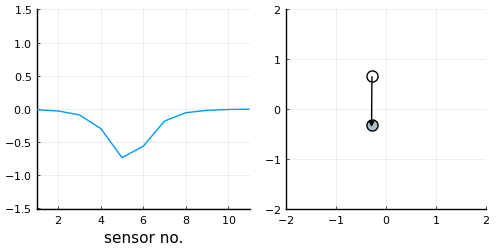

In [28]:
showmode(50,1,solhist,config_1vortex_data,size=(500,250),markersize=8,xlim=(-2.0,2.0),ylim=(-2.0,2.0))

In [29]:
solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)

3×3 Matrix{Float64}:
  0.0409346    2.0098e-5    0.00184311
 -5.94799e-5   0.0924307    0.000353381
  0.000312875  0.000422218  0.595419

### Multiple vortices

In [30]:
Nv = 3
δ = 0.01

config_data = VortexConfig(Nv, δ, body=LowRankVortex.NoWall)

# prior
ϵmeas = 5e-4 #5e-4 #1e-3
ϵX = 5e-3 #5e-3 #0.05
ϵΓ = 5e-3 #5e-3 #0.05

# ranges to confine the prior to
xr = (-1.5,1.5)
yr = (0.0,1.5)
Γr = (0.0,2.0)

(0.0, 2.0)

In [56]:
sol_collection = vortexinference(Nv,sens,ystar,xr,yr,Γr,ϵmeas,ϵX,ϵX,ϵΓ,config_data,linear_flag=false,maxiter=100,numsample=20,inflate=true);

In [57]:
collection_err = map(x -> x[end].yerr,sol_collection)

20-element Vector{Float64}:
  10.870212007242461
 170.07716507222452
  14.603146766752792
  40.632460058157754
  10.461636370700784
   9.490524585993114
 134.8130278386546
   5.18628495947525
  20.689917014218135
  10.672389144512746
 259.86847342336944
 265.11302754512906
  12.114116038240013
   8.485258888935562
  18.29856558178843
   3.6537960693738243
   5.105108773453298
   5.2326948751916005
   2.963520113624038
 216.34353589351102

In [58]:
perr = []
for solhist in sol_collection
    jdex = length(solhist)
    vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
    p_post_field = analytical_pressure(zg,vort_post,config_data)
    push!(perr,norm(ptrue_field-p_post_field)/norm(ptrue_field))
end

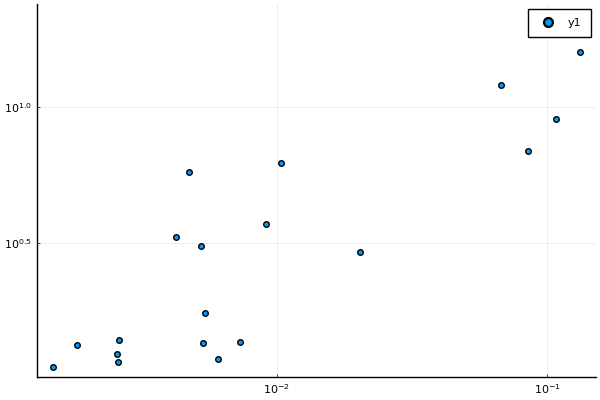

In [59]:
scatter(collection_err*ϵmeas,perr,scale=:log10)

In [60]:
minerr, sampnum = findmin(collection_err)
solhist = sol_collection[sampnum];

In [61]:
minerr

2.963520113624038

In [62]:
perr[sampnum]

1.104478017870834

In [677]:
minperr, sampnum = findmin(perr)
solhist = sol_collection[sampnum];
minerr = collection_err[sampnum]

8.555369230739387

In [918]:
minerr*ϵmeas

0.000823171294532819

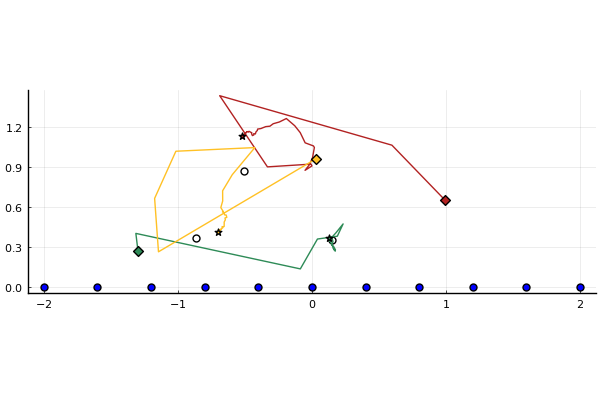

In [63]:
pl = filtertrajectory(solhist,sens,vort,config_data,markersize=5,legend=false)
#savefig("3cluster-traj-3vortex-11linesensors.pdf")
#display(pl)

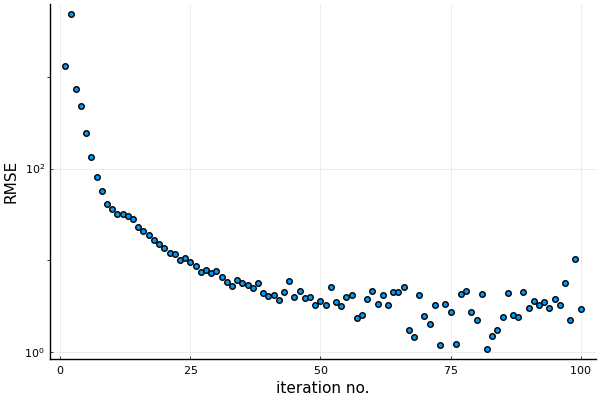

In [64]:
yerrhist = map(x -> x.yerr,solhist)
scatter(yerrhist,yscale=:log10,xlabel="iteration no.",ylabel="RMSE",legend=false)

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/lW9ll/src/animation.jl:137


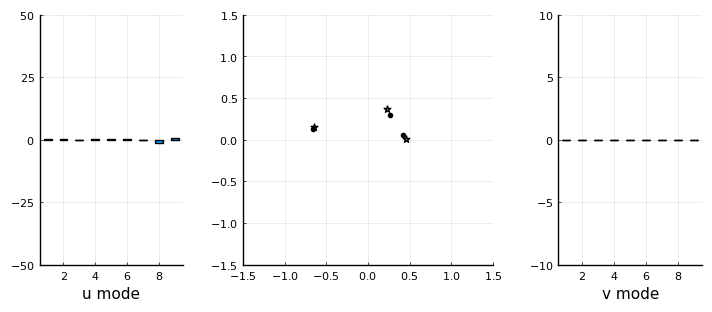

Plots.AnimatedGif("/Users/jeff/JuliaProjects/LowRankVortex/stationary/tmp.gif")
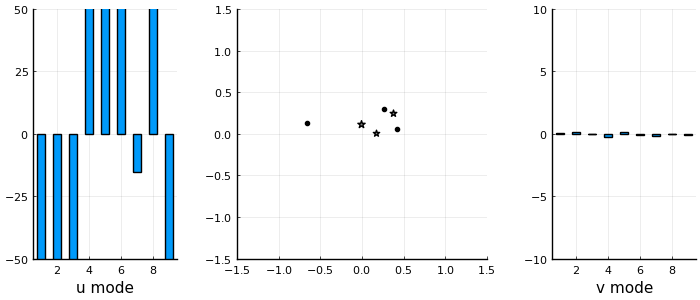

In [778]:
@gif for j in 1:length(solhist)
    filterstepplot(j,solhist,x_true,xlim=(-1.5,1.5),ylim=(-1.5,1.5),size=(700,300),arrows_on=false,ubarscale=0.1,vbarscale=0.1)
end every 2

The Kalman gain isn't diagonally dominant. Mixes U and V modes together. In particular, higher U modes affect most V modes.

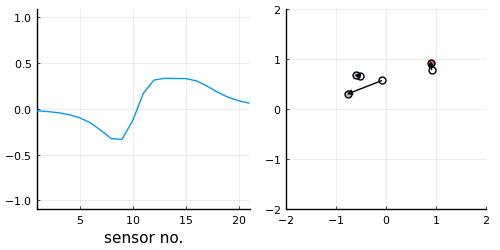

In [344]:
showmode(100,2,solhist,config_data,size=(500,250),xlim=(-2,2),ylim=(-2,2))

In [345]:
(solhist[end].ΣX̆Y̆*inv(solhist[end].ΣY̆)).diag

9-element Vector{Float64}:
 0.26691182937350977
 0.4612485658255621
 0.4992840956956534
 0.48894157312115305
 0.40584969917653485
 0.35102396492451765
 0.30115145006403
 0.1261610131156297
 0.057328954009867435

In [65]:
jdex = length(solhist)
vort_post = state_to_lagrange_reordered(mean(solhist[jdex].X),config_data;isblob=true);
zv_post = Elements.position(vort_post);
Γ_post = LowRankVortex.strength(vort_post);
y_post = analytical_pressure(sens,vort_post,config_data)
p_post_field = analytical_pressure(zg,vort_post,config_data)
vort_post

3-element Vector{PotentialFlow.Blobs.Blob{Float64, Float64}}:
 Vortex.Blob(-0.5169431841207696 + 1.1245175849923899im, 1.0638755835247526, 0.01)
 Vortex.Blob(0.12415099009299205 + 0.3649116342154539im, 1.6238157795595674, 0.01)
 Vortex.Blob(-0.7038972196987423 + 0.4151225003595821im, 1.6834903228795832, 0.01)

In [66]:
vortexmoment(1,zv_post,Γ_post)

-1.53336905255936 + 2.4877507838664803im

In [67]:
vortexmoment(1,zv,Γv)

-1.5888933471547861 + 2.5957058796524626im

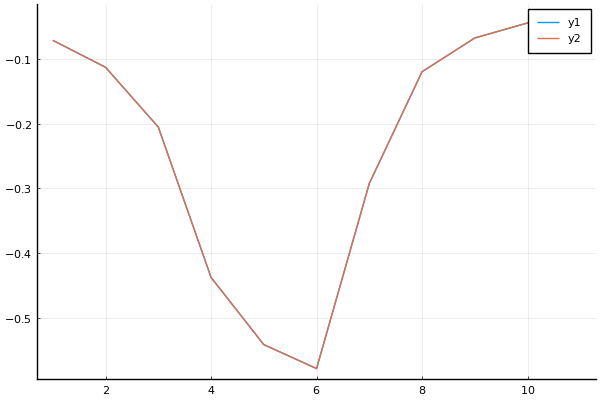

In [68]:
plot(y_post)
plot!(ystar)

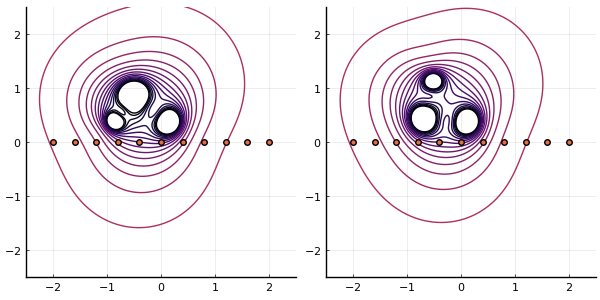

In [69]:
l = range(-1,1,length=31)
cl = (-1,1)
pl1 = plot(xg,yg,ptrue_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
scatter!(pl1,real.(sens),imag.(sens))
#plot!(x,y,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
pl2 = plot(xg,yg,p_post_field',ratio=1,levels=l,clim=cl,legend=false,xlim=(xmin,xmax),ylim=(xmin,xmax))
scatter!(pl2,real.(sens),imag.(sens))
p1 = plot(pl1,pl2,size=(600,300))
#savefig("3cluster-pfield-3vortex-11linesensors.pdf")
#display(p1)

In [46]:
norm(ptrue_field-p_post_field)/norm(ptrue_field)

1.0556392962289902

### Explore the cost function topology
Here, we will map out the cost function's dependence on two components of the state, while
keeping the others fixed.

In [1591]:
# start with the final mean state
xmin, xmax = -2.5, 2.5
xg = range(xmin,xmax,length=201)
yg = range(xmin,xmax,length=201)

jdex = 500 #length(solhist)
xbase = mean(solhist[jdex].X)

costmap = zeros(length(xg),length(yg))
costmap_p = zeros(length(xg),length(yg))
costmap_m = zeros(length(xg),length(yg))

xij = copy(xbase)

v_explore = 3

for (j,yj) in enumerate(yg)
    xij[2v_explore] = yj
    for (i,xi) in enumerate(xg)
        xij[2v_explore-1] = xi
        hx = observations(xij,pressure,sens,config_data)
        costmap[i,j] = norm(ystar-hx,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore] + 0.05
        hx_p = observations(xij,pressure,sens,config_data)
        costmap_p[i,j] = norm(ystar-hx_p,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore] - 0.05
        hx_m = observations(xij,pressure,sens,config_data)
        costmap_m[i,j] = norm(ystar-hx_m,Σϵ)
        xij[2Nv+v_explore] = xbase[2Nv+v_explore]
    end
end

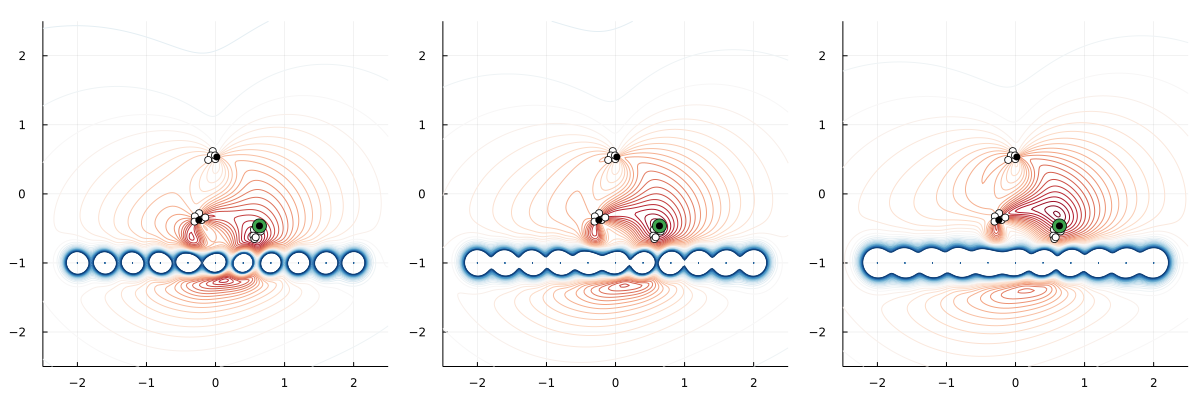

In [1592]:
truex = x_true[1:2:2Nv_true]
truey = x_true[2:2:2Nv_true]
currentx = xbase[1:2:2Nv]
currenty = xbase[2:2:2Nv]
minc = 0.3 #minimum([minimum(costmap_p),minimum(costmap),minimum(costmap_m)])
p1 = plot(xg,yg,costmap',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1,truex,truey,markercolor=:white,legend=false)
scatter!(p1,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_p = plot(xg,yg,costmap_p',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_p,truex,truey,markercolor=:white,legend=false)
scatter!(p1_p,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_p,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

p1_m = plot(xg,yg,costmap_m',ratio=1,levels=range(minc,minc+50,length=41),clim=(minc,minc+50),colorbar=false,color=:RdBu)
scatter!(p1_m,truex,truey,markercolor=:white,legend=false)
scatter!(p1_m,[xbase[2v_explore-1]],[xbase[2v_explore]],markersize=8)
scatter!(p1_m,currentx,currenty,markercolor=:black,xlim=(-2.5,2.5),ylim=(-2.5,2.5))

plot(p1_m,p1,p1_p,layout=(1,3),size=(1200,400))

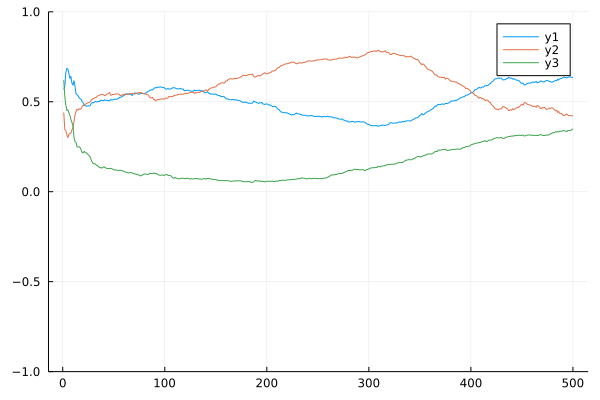

In [1571]:
plot(map(x -> mean(x.X)[2Nv+1],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+2],solhist),ylim=(-1,1))
plot!(map(x -> mean(x.X)[2Nv+3],solhist),ylim=(-1,1))

In [555]:
#=
q = 10
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

i1, j1 = 3, 7
P = zeros(q,q)
for j in 1:q
    P[j,j] = 1.0
end
v = P[:,i1]
P[:,i1] .= P[:,j1]
P[:,j1] .= v
P;

dθ = Uniform(0,π)
dln = LogNormal(-2,1);;
[mean(dln) std(dln)]

dθ = Uniform(0,π)
dln = LogNormal(-2,1);
#dln = Chi(2);

q = 40
A = zeros(q,q)
A[1,:] .= 1.0/q
for j in 2:q
    A[j,j-1] = -1.0
    A[j,j] = 1.0
end
A

x̃, ỹ = zeros(q), zeros(q)
for j in 2:q
    zj = rand(dln)*exp(im*rand(dθ))
    x̃[j] = real(zj)
    ỹ[j] = imag(zj)
end

x = inv(A)*x̃;
y = inv(A)*ỹ;
scatter(x,y,ratio=1)
=#

In [302]:
dy̆ = hcat(map(x -> vcat(mean(x.Y̆),zeros(6-length(mean(x.Y̆)))),solhist)...);

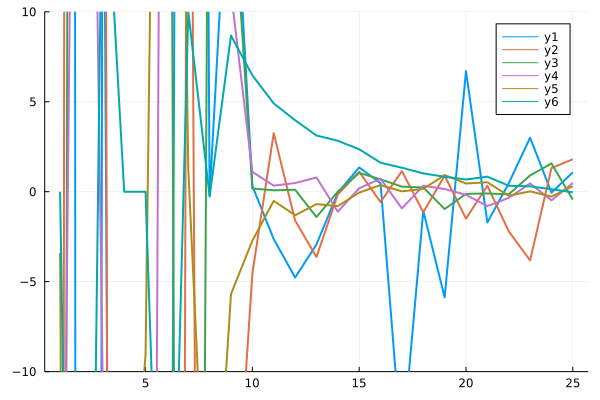

In [312]:
plot(dy̆[1,:],linewidth=2,ylim=(-10,10))
plot!(dy̆[2,:],linewidth=2)
plot!(dy̆[3,:],linewidth=2)
plot!(dy̆[4,:],linewidth=2)
plot!(dy̆[5,:],linewidth=2)
plot!(dy̆[6,:],linewidth=2)

In [290]:
dx̆ = hcat(map(x -> mean(x.ΣX̆Y̆*(x.ΣY̆\x.Y̆)),solhist)...);

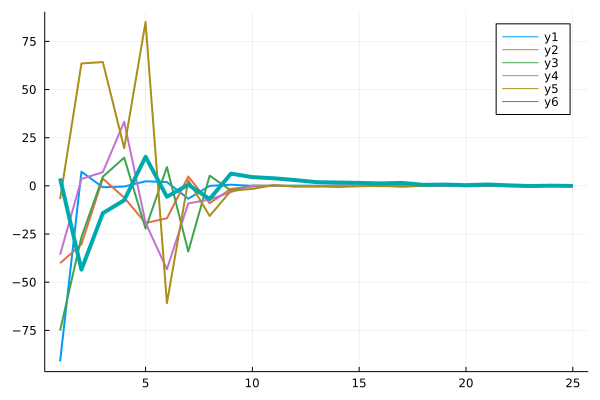

In [306]:
plot(dx̆[1,:],linewidth=2)
plot!(dx̆[2,:],linewidth=2)
plot!(dx̆[3,:],linewidth=2)
plot!(dx̆[4,:],linewidth=2)
plot!(dx̆[5,:],linewidth=2)
plot!(dx̆[6,:],linewidth=4)

In [79]:
sqrt(Σx)*Fhist[end].V[:,1:rhist[end]]*K̃*ỹhist[end]

9-element Vector{Float64}:
  0.0018490395330256174
 -0.005118568346242631
 -0.00357188260657286
 -0.00446458150403976
  0.008487842822575746
  0.007777494563758844
  0.0025521443428678826
  0.0045746465120252025
  0.0025497897622294495

36-element Vector{Float64}:
 1321.9159271767949
  197.92969822660362
   60.65322971203477
   14.070451613159014
    2.524231697075501
    0.08879175290868446
    0.0024909038486424285
    0.0003641957099004161
    8.743238899015276e-5
    1.1374831855011818e-5
    1.1561468627527092e-6
    6.920089409510231e-9
    2.6473141167366238e-9
    ⋮
    2.4868995751603507e-14
    2.259396132881637e-14
    1.4422580366206255e-14
    1.4210854715202004e-14
    1.0552812029956029e-14
    9.978272503795993e-15
    9.166656117039269e-15
    7.54697596667468e-15
    7.105427357601002e-15
    5.985093828153431e-15
    5.80939686960131e-15
    4.273885897591831e-15

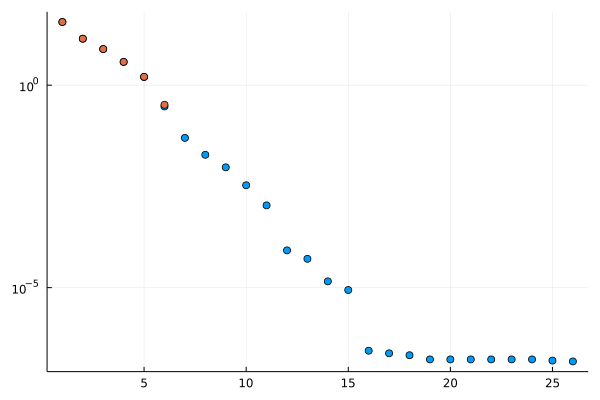

In [218]:
Λx = solhist[end].Λx[solhist[end].Λx.>100*eps()]
Λy = solhist[end].Λy[solhist[end].Λy.>100*eps()]
pl = scatter(sqrt.(Λy),yscale=:log10,legend=false)
scatter!(pl,sqrt.(Λx),yscale=:log10,legend=false)

#savefig("4vortex-svalues.pdf")
#savefig("4vortex-svalues.png")
display(pl)

In [98]:
LowRankVortex.P

9×9 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.0459763   0.180721    -0.466078   -0.664597   …  -0.231686    0.0589482
  0.0788804   0.00428573   0.5093      0.0835935      0.144961    0.278253
  0.16449    -0.0732933   -0.140497    0.307257      -0.443203    0.0570702
  0.826368   -0.026383    -0.299224    0.252782      -0.0776115  -0.0232306
 -0.231958    0.659137    -0.13104     0.492813       0.098887    0.0212657
 -0.0686195   0.535204    -0.0629612   0.0229107  …  -0.31879    -0.054013
 -0.0602487  -0.0762433   -0.49928     0.106125       0.689798   -0.213156
 -0.280826   -0.279705    -0.361859    0.22372       -0.0813069   0.771225
 -0.375122   -0.395349    -0.112926    0.297177      -0.359191   -0.521258

In [99]:
V[1:2,1] + V[4:5,1] + V[7:8,1]

2-element Vector{Float64}:
  0.7201431166604436
 -0.43390344986838764

In [961]:
unitvec = zeros(length(x_post))
unitvec[6] = 1.0
F.Vt*unitvec

6-element Vector{Float64}:
  0.574771771360253
  0.22247709382174288
 -0.3319587477794311
  0.11918085260192823
 -0.24380484125187668
  0.6605299895538166

In [1318]:
F.V[:,1]

9-element Vector{Float64}:
 -0.0013365146346376764
 -0.3437027395751458
  0.0829705149437211
 -0.3194680056247702
 -0.08144756026540528
 -0.32315728742537086
  0.259381193123849
  0.5453208346181756
  0.5451650888170947

In [1319]:
cumsum(F.S)/sum(F.S)

9-element Vector{Float64}:
 0.5459333120939325
 0.7545316235684618
 0.8396933430067108
 0.9155493243748806
 0.9677749179838403
 0.9879966879557416
 0.9990439288567136
 0.9997043000270978
 0.9999999999999999